In [ ]:
pip install tensorflow


# Data Loading and Preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
data=pd.read_csv("/content/drive/MyDrive/SN_ms_tot_V2.0.csv", header=0)

data = data.sort_values("Decimal_date").reset_index(drop=True)
data = data[:-7]

values = data[" ms_sn"].values
Decimal_date = data["Decimal_date"].values
month = data["Month"].values
year = data["Year"].values
df=pd.DataFrame({
    "values":values,
    "Decimal_date":Decimal_date,
    "month":month,
    "year":year
})


In [ ]:
import numpy as np
CYCLE_LENGTH=132
# Convert dates to integer months since start
df["month_index"] = np.arange(len(df))

# Add cyclical features
df["sin_cycle"] = np.sin(2 * np.pi * df["month_index"] / CYCLE_LENGTH)
df["cos_cycle"] = np.cos(2 * np.pi * df["month_index"] / CYCLE_LENGTH)


## Seasonality Check

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt
import pandas as pd

data_m=pd.read_csv("/content/drive/MyDrive/SN_m_tot_V2.0.csv", header=0)

# Convert Decimal_date to datetime and set as index
data_m['Date'] = pd.to_datetime(data_m['Decimal_date'], origin='julian', unit='D')
data_m = data_m.set_index('Date')


# Assume df['values'] is your time series
result = seasonal_decompose(df['values'], model='additive', period=132)
m=len(data_m)
stl = STL(data_m['m_sn'], seasonal=12) # Set seasonal period to 12 for monthly data
result_stl = stl.fit()
#result.plot()
result_stl.plot()
plt.show()
plt.savefig('decomposition_plot.eps', format='eps', dpi=300)

ValueError: Unable to determine period from endog

## ACF and PACF PLOT

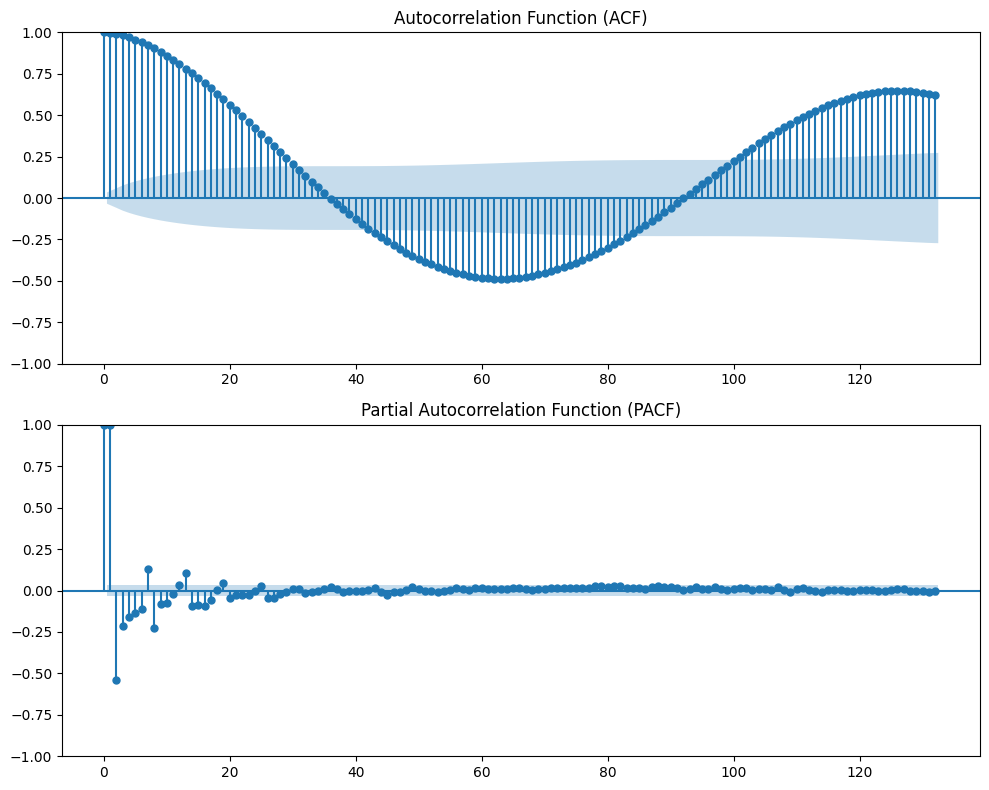

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

data = df['values'].values
# Plot ACF and PACF
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

plot_acf(data, ax=ax[0], lags=132, title="Autocorrelation Function (ACF)")
plot_pacf(data, ax=ax[1], lags=132, title="Partial Autocorrelation Function (PACF)", method='ywm')

plt.tight_layout()
plt.show()
plt.savefig('acf_pacf_plot.eps', format='eps', dpi=300)

## Spectral Analysis

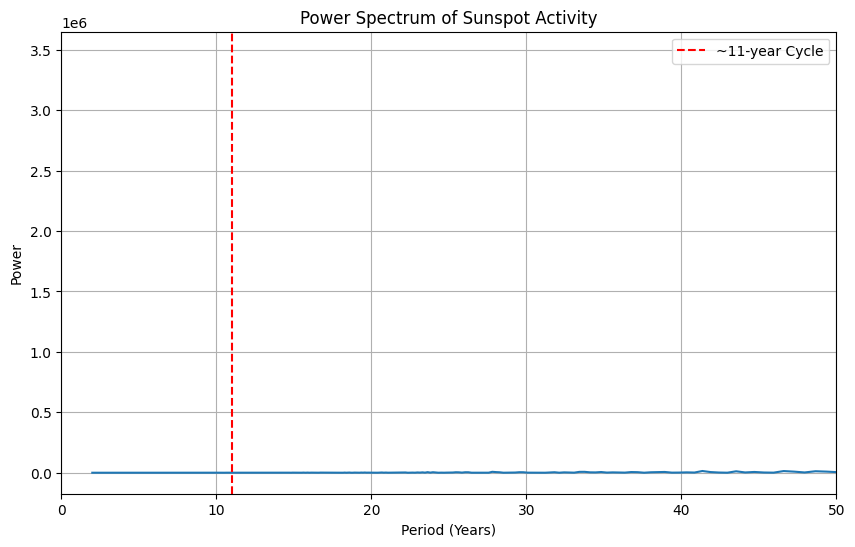

In [ ]:
#not working
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import periodogram

# Load example sunspot data (can be replaced with your own)
from statsmodels.datasets import sunspots
#data = sunspots.load_pandas().data
#data['year'] = df['year'].astype(int) # This line caused the error
ts = df['values'].values
years = df['year'].values

# Remove mean to focus on cyclic components
ts_detrended = ts - np.mean(ts)

# Compute power spectrum using FFT-based periodogram
freqs, power = periodogram(ts_detrended, fs=1)  # fs=1 because data is annual

# Convert frequency to period in years
periods = 1 / freqs[1:]  # skip the zero frequency (DC component)
power = power[1:]

# Plot Power Spectrum
plt.figure(figsize=(10, 6))
plt.plot(periods, power)
plt.xlabel('Period (Years)')
plt.ylabel('Power')
plt.title('Power Spectrum of Sunspot Activity')
plt.xlim(0, 50)
plt.grid(True)
plt.axvline(x=11, color='r', linestyle='--', label='~11-year Cycle')
plt.legend()
plt.show()

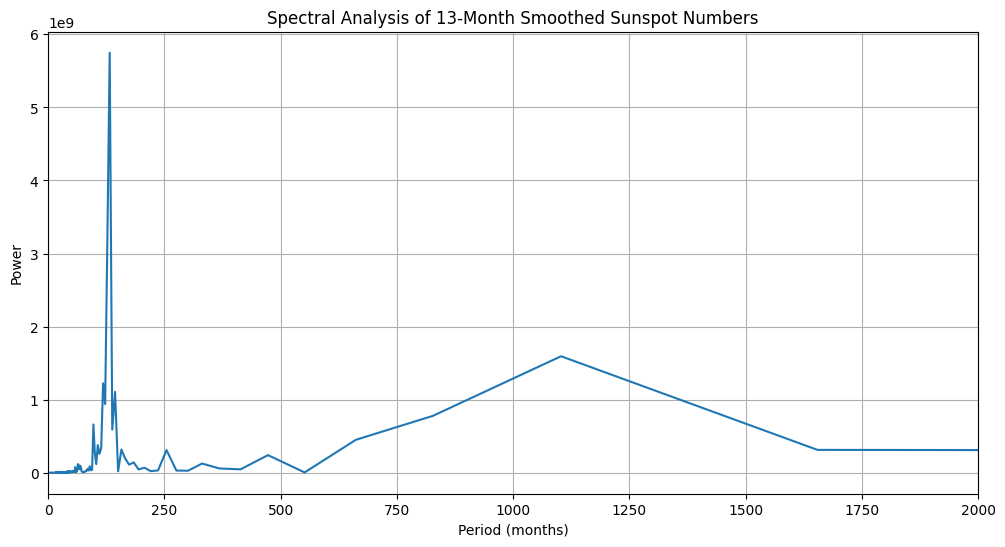

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

# Ensure 'Date' is datetime and set as index
df['Date'] = pd.to_datetime(df['year'])
df = df.set_index('Date')

# Use the 13-month smoothed sunspot numbers
ts = df['values'].values

# Detrend the series (remove mean)
ts_detrended = ts - ts.mean()

# Parameters
N = len(ts_detrended)         # Number of data points
T = 1                         # Sampling period = 1 month

# FFT
'''yf = fft(ts_detrended)
xf = fftfreq(N, T)[:N//2]
power = np.abs(yf[:N//2])**2'''

# FFT
yf = fft(ts_detrended)
xf = fftfreq(N, T)

# Skip the zero frequency
xf = xf[1:N//2]
power = np.abs(yf[1:N//2])**2


# Convert frequency to period (in months)
period = 1 / xf

# Plot power vs period
plt.figure(figsize=(12, 6))
plt.plot(period, power)
plt.title("Spectral Analysis of 13-Month Smoothed Sunspot Numbers")
plt.xlabel("Period (months)")
plt.ylabel("Power")
plt.xlim(0, 2000)  # Adjust to show long-term cycles (e.g., Gleissberg)
plt.grid(True)
plt.show()
plt.savefig('spectral_analysis_plot.eps', format='eps', dpi=300)

 # Chronological Train- Validation-Test Split

In [ ]:
#feature_cols = ['values_scaled', 'month_scaled', 'year_scaled']
feature_cols = ['values', 'year', 'sin_cycle', 'cos_cycle']
data_ = df[feature_cols].values

# 60% train, 20% validation, 20% test
train_end = int(0.6 * len(data_))
val_end = int(0.8 * len(data_))

# Splitting the sequences
data_train = data_[:train_end,]
data_val= data_[train_end:val_end,]
data_test = data_[val_end:,]


In [ ]:
print(data_train.shape,data_train.shape)
print(data_val.shape,data_val.shape)
print(data_test.shape,data_test.shape)
#print(y_test)

(1985, 4) (1985, 4)
(662, 4) (662, 4)
(662, 4) (662, 4)


In [ ]:
print(data_train[-1],data_val[0])
print(df.iloc[1984],df.iloc[1985])
print(data_val[-1],data_test[0],data_test[-1])
print(df.iloc[2649],df.iloc[2650],df.iloc[3308])

[0.04685315 0.36363636 0.6       ] [0.05524476 0.45454545 0.6       ]
values             12.400000
Decimal_date     1914.371000
month               5.000000
year             1914.000000
values_scaled       0.046853
month_scaled        0.363636
year_scaled         0.600000
Name: 1970-01-01 00:00:00.000001914, dtype: float64 values             14.800000
Decimal_date     1914.455000
month               6.000000
year             1914.000000
values_scaled       0.055245
month_scaled        0.454545
year_scaled         0.600000
Name: 1970-01-01 00:00:00.000001914, dtype: float64
[0.52762238 0.54545455 0.8       ] [0.53041958 0.63636364 0.8       ] [0.56048951 0.72727273 1.        ]
values            147.400000
Decimal_date     1969.790000
month              10.000000
year             1969.000000
values_scaled       0.518881
month_scaled        0.818182
year_scaled         0.800000
Name: 1970-01-01 00:00:00.000001969, dtype: float64 values            148.000000
Decimal_date     1969.874000
mo

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

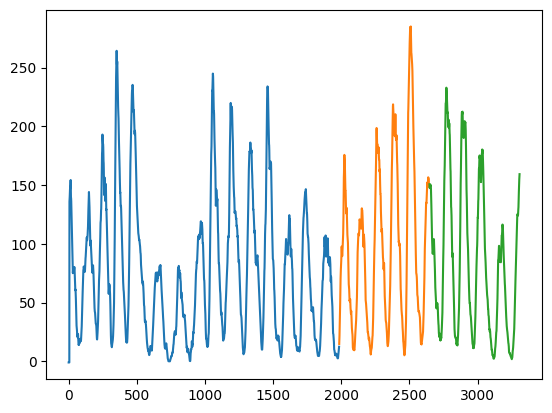

In [ ]:
import matplotlib.pyplot as plt
#ind=[0:3308]
ind=list(range(len(data_)))
print(ind)
plt.plot(ind[:train_end],data_[:train_end,0])
plt.plot(ind[train_end:val_end],data_[train_end:val_end,0])
plt.plot(ind[val_end:],data_[val_end:,0])
plt.show()

## Data Scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Assume df has 'value', 'month', 'year' columns
scalers = {}
for col in ['values', 'month', 'year', 'sin_cycle', 'cos_cycle']:
    scaler = MinMaxScaler()
    #df[col + '_scaled'] = scaler.fit_transform(df[[col]])

    # Fit only on training data
    data_train[col + '_scaled'] = scaler.fit_transform(data_train[[col]])

    # Transform test and validation data using same scaler
    data_val[col + '_scaled'] = scaler.transform(data_val[[col]])
    data_test[col + '_scaled'] = scaler.transform(data_test[[col]])
    scalers[col] = scaler


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

## split then scaling using data frames

In [ ]:
from sklearn.preprocessing import MinMaxScaler

#feature_cols = ['values', 'year', 'sin_cycle', 'cos_cycle']
feature_cols = ['values', 'year']
data_ = df[feature_cols]   # <-- keep as DataFrame

# 60% train, 20% validation, 20% test
train_end = int(0.6 * len(data_))
val_end = int(0.8 * len(data_))

# Splitting
data_train = data_.iloc[:train_end].copy()
data_val   = data_.iloc[train_end:val_end].copy()
data_test  = data_.iloc[val_end:].copy()

scalers = {}
for col in feature_cols:
    scaler = MinMaxScaler()

    # Fit on training
    data_train[col + '_scaled'] = scaler.fit_transform(data_train[[col]])

    # Transform val/test
    data_val[col + '_scaled']  = scaler.transform(data_val[[col]])
    data_test[col + '_scaled'] = scaler.transform(data_test[[col]])
    df[col + '_scaled'] = scaler.transform(df[[col]])

    scalers[col] = scaler


In [ ]:
df.head()

,values,Decimal_date,month,year,Date,year_scaled,values_scaled
0,-1.0,1749.042,1,1749,1749-01-16 07:55:11.999997364,0.0,0.0
1,-1.0,1749.123,2,1749,1749-02-14 21:28:48.000001494,0.0,0.0
2,-1.0,1749.204,3,1749,1749-03-16 11:02:23.999998453,0.0,0.0
3,-1.0,1749.288,4,1749,1749-04-16 02:52:48.000000345,0.0,0.0
4,-1.0,1749.371,5,1749,1749-05-16 09:57:36.000002980,0.0,0.0


## split then scaling using numpy array

In [ ]:
from sklearn.preprocessing import MinMaxScaler

feature_cols = ['values', 'year', 'sin_cycle', 'cos_cycle']
data_ = df[feature_cols].values  # now it's NumPy array

# Split
train_end = int(0.6 * len(data_))
val_end = int(0.8 * len(data_))

data_train = data_[:train_end]
data_val   = data_[train_end:val_end]
data_test  = data_[val_end:]

# Scale all features together
scaler = MinMaxScaler()
data_train_scaled = scaler.fit_transform(data_train)
data_val_scaled   = scaler.transform(data_val)
data_test_scaled  = scaler.transform(data_test)


KeyError: "['sin_cycle', 'cos_cycle'] not in index"

## Linear Regression

In [ ]:
X_train = data_train.values[:, 1:]

In [ ]:
print(data_train)

      values  year     sin_cycle  cos_cycle  values_scaled  year_scaled  \
0       -1.0  1749  0.000000e+00   1.000000       0.000000          0.0   
1       -1.0  1749  4.758192e-02   0.998867       0.000000          0.0   
2       -1.0  1749  9.505604e-02   0.995472       0.000000          0.0   
3       -1.0  1749  1.423148e-01   0.989821       0.000000          0.0   
4       -1.0  1749  1.892512e-01   0.981929       0.000000          0.0   
...      ...   ...           ...        ...            ...          ...   
1980     7.7  1914  3.431487e-15   1.000000       0.032793          1.0   
1981     8.5  1914  4.758192e-02   0.998867       0.035809          1.0   
1982     9.8  1914  9.505604e-02   0.995472       0.040709          1.0   
1983    10.9  1914  1.423148e-01   0.989821       0.044855          1.0   
1984    12.4  1914  1.892512e-01   0.981929       0.050509          1.0   

      sin_cycle_scaled  cos_cycle_scaled  
0             0.500000          1.000000  
1            

In [ ]:
print(X_train)

[[1.74900000e+03 0.00000000e+00 1.00000000e+00 ... 0.00000000e+00
  5.00000000e-01 1.00000000e+00]
 [1.74900000e+03 4.75819158e-02 9.98867339e-01 ... 0.00000000e+00
  5.23790958e-01 9.99433670e-01]
 [1.74900000e+03 9.50560433e-02 9.95471923e-01 ... 0.00000000e+00
  5.47528022e-01 9.97735961e-01]
 ...
 [1.91400000e+03 9.50560433e-02 9.95471923e-01 ... 1.00000000e+00
  5.47528022e-01 9.97735961e-01]
 [1.91400000e+03 1.42314838e-01 9.89821442e-01 ... 1.00000000e+00
  5.71157419e-01 9.94910721e-01]
 [1.91400000e+03 1.89251244e-01 9.81928697e-01 ... 1.00000000e+00
  5.94625622e-01 9.90964349e-01]]


In [ ]:
data_train_scaled=data_train.iloc[:,2:]
data_val_scaled=data_val.iloc[:,2:]
data_test_scaled=data_test.iloc[:,2:]
data_total_scaled=df.iloc[:,5:]
print(  data_train_scaled)
print(  data_val_scaled)
print(  data_test_scaled)
print(  data_total_scaled)

      values_scaled  year_scaled
0          0.000000          0.0
1          0.000000          0.0
2          0.000000          0.0
3          0.000000          0.0
4          0.000000          0.0
...             ...          ...
1980       0.032793          1.0
1981       0.035809          1.0
1982       0.040709          1.0
1983       0.044855          1.0
1984       0.050509          1.0

[1985 rows x 2 columns]
      values_scaled  year_scaled
1985       0.059555     1.000000
1986       0.069732     1.000000
1987       0.085187     1.000000
1988       0.104787     1.000000
1989       0.120618     1.000000
...             ...          ...
2642       0.580098     1.333333
2643       0.571806     1.333333
2644       0.570675     1.333333
2645       0.569544     1.333333
2646       0.568790     1.333333

[662 rows x 2 columns]
      values_scaled  year_scaled
2647       0.571806     1.333333
2648       0.566152     1.333333
2649       0.559367     1.333333
2650       0.561628     1.3

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import random
import numpy as np

# Fix seed value
SEED = 42

random.seed(SEED)
np.random.seed(SEED)



# Split features and target
X_train = data_train_scaled.values[:, 1:]  # 'year_scaled', 'sin_cycle_scaled', 'cos_cycle_scaled'
y_train = data_train_scaled.values[:, 0]   # 'values_scaled'

X_val = data_val_scaled.values[:, 1:]
y_val = data_val_scaled.values[:, 0]

X_test = data_test_scaled.values[:, 1:]
y_test = data_test_scaled.values[:, 0]

# Initialize and fit linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Evaluation
train_rmse = np.sqrt(mean_squared_error(scalers['values'].inverse_transform(y_train.reshape(-1, 1)).flatten(), scalers['values'].inverse_transform(y_train_pred.reshape(-1, 1)).flatten()))
val_rmse = np.sqrt(mean_squared_error(scalers['values'].inverse_transform(y_val.reshape(-1, 1)).flatten(), scalers['values'].inverse_transform(y_val_pred.reshape(-1, 1)).flatten()))
test_rmse = np.sqrt(mean_squared_error(scalers['values'].inverse_transform(y_test.reshape(-1, 1)).flatten(), scalers['values'].inverse_transform(y_test_pred.reshape(-1, 1)).flatten()))

train_mae = mean_absolute_error(scalers['values'].inverse_transform(y_train.reshape(-1, 1)).flatten(), scalers['values'].inverse_transform(y_train_pred.reshape(-1, 1)).flatten())
val_mae = mean_absolute_error(scalers['values'].inverse_transform(y_val.reshape(-1, 1)).flatten(), scalers['values'].inverse_transform(y_val_pred.reshape(-1, 1)).flatten())
test_mae = mean_absolute_error(scalers['values'].inverse_transform(y_test.reshape(-1, 1)).flatten(), scalers['values'].inverse_transform(y_test_pred.reshape(-1, 1)).flatten())


print(f"Train RMSE: {train_rmse:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Train MAE: {train_mae:.4f}")
print(f"Validation MAE: {val_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")

Train RMSE: 59.0984
Validation RMSE: 77.9975
Test RMSE: 70.8532
Train MAE: 48.1252
Validation MAE: 60.5499
Test MAE: 55.6726


# Feature Engineering

In [ ]:
def create_multifeature_sequences(df, seq_length, output_steps):
    #feature_cols = ['values_scaled', 'month_scaled', 'year_scaled']
    #data_ = df[feature_cols].values

    X, y = [], []
    for i in range(len(df) - seq_length - output_steps + 1):
        X.append(df[i:i + seq_length])
        y.append(df[i + seq_length : i + seq_length + output_steps, 0])  # only value_scaled
    return np.array(X), np.array(y)

seq_length = 13
X_train, y_train = create_multifeature_sequences(data_train_scaled.values, seq_length,output_steps=13)
X_val, y_val = create_multifeature_sequences(data_val_scaled.values, seq_length,output_steps=13)
X_test, y_test = create_multifeature_sequences(data_test_scaled.values, seq_length,output_steps=13)
X_total, y_total = create_multifeature_sequences(data_total_scaled.values, seq_length,output_steps=13)
#print(X.shape)  # (samples, seq_length, 3)
#print(y.shape)  # (samples,)


In [ ]:
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)
print(y_test)

(1960, 13, 2) (1960, 13)
(637, 13, 2) (637, 13)
(637, 13, 2) (637, 13)
[[0.52242744 0.50471165 0.48058801 ... 0.35318507 0.34866189 0.35506973]
 [0.50471165 0.48058801 0.45231813 ... 0.34866189 0.35506973 0.35733132]
 [0.48058801 0.45231813 0.43271768 ... 0.35506973 0.35733132 0.36072371]
 ...
 [0.47342631 0.47229551 0.47116472 ... 0.56577459 0.57972107 0.58801357]
 [0.47229551 0.47116472 0.47418017 ... 0.57972107 0.58801357 0.59479834]
 [0.47116472 0.47418017 0.48586506 ... 0.58801357 0.59479834 0.60422164]]


In [ ]:
X_train.shape[2]

2

# Model Training

## Stacked LSTM

In [ ]:
import numpy as np
import random
import tensorflow as tf

SEED = 9
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

early_stop = EarlyStopping(patience=10, restore_best_weights=True)
model_lstm = Sequential([
    LSTM(16,  activation='tanh', input_shape=(seq_length,  X_train.shape[2])),
    #LSTM(64, return_sequences=True),
    #LSTM(16),
    Dropout(0.5),
    Dense(13)
])
optimizer = Adam(learning_rate=0.001)
#optimizer = Adam(clipnorm=1.0)
model_lstm.compile(optimizer=optimizer, loss='mse')
history_lstm=model_lstm.fit(X_train, y_train, epochs= 100, batch_size=16,validation_data=(X_val, y_val),callbacks=[early_stop] )
model_lstm.save("solar_cycle_lstm.h5")


Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1412 - val_loss: 0.0608
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0449 - val_loss: 0.0353
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0303 - val_loss: 0.0282
Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0253 - val_loss: 0.0221
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0194 - val_loss: 0.0191
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0165 - val_loss: 0.0138
Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0143 - val_loss: 0.0121
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0130 - val_loss: 0.0103
Epoch 9/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0126 - val_loss: 0.0101
Epoch 10/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0116 - val_loss: 0.0081
Epoch 11/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0099 - val_loss: 0.0076
Epoch 12/100
123/123 ━━━━━━━━━━━━━━━━━━━

## GRU

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

model_gru = Sequential([
    GRU(32, activation='tanh', input_shape=(seq_length, X_train.shape[2]), return_sequences=False),
    Dropout(0.2),
    Dense(13)  # output 13 values at a time
])
optimizer = Adam(learning_rate=0.001)
model_gru.compile(optimizer=optimizer, loss='mse')

# Early stopping to prevent overfitting
early_stop = EarlyStopping(patience=10, restore_best_weights=True)

history_gru=model_gru.fit(X_train, y_train, epochs=100, batch_size=16,validation_data=(X_val, y_val), callbacks=[early_stop])
model_gru.save("solar_cycle_gru.h5")


Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1000 - val_loss: 0.0307
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0192 - val_loss: 0.0193
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0137 - val_loss: 0.0150
Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0100 - val_loss: 0.0086
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0082 - val_loss: 0.0082
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0076 - val_loss: 0.0082
Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0072 - val_loss: 0.0090
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0071 - val_loss: 0.0087
Epoch 9/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0063 - val_loss: 0.0080
Epoch 10/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0064 - val_loss: 0.0072
Epoch 11/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0061 - val_loss: 0.0092
Epoch 12/100
123/123 ━━━━━━━━━━━━━━━━━━━

## Stacking Features

In [ ]:
model_lstm.fit(X_total, y_total, epochs= 40, batch_size=16,callbacks=[early_stop])

Epoch 1/40
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0140
Epoch 2/40
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0064
Epoch 3/40
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0050
Epoch 4/40
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0045
Epoch 5/40
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0042
Epoch 6/40
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0038
Epoch 7/40
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0036
Epoch 8/40
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0036
Epoch 9/40
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0034
Epoch 10/40
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0030
Epoch 11/40
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0031
Epoch 12/40
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0027
Epoch 13/40
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0025
Epoch 14/40
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0027
Epoch 15/40
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s

In [ ]:
model_gru.fit(X_total, y_total, epochs=100, batch_size=16, callbacks=[early_stop])

Epoch 1/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0086
Epoch 2/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0056
Epoch 3/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0044
Epoch 4/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0046
Epoch 5/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0038
Epoch 6/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0037
Epoch 7/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0038
Epoch 8/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0031
Epoch 9/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0029
Epoch 10/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0028
Epoch 11/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0027
Epoch 12/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0027
Epoch 13/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0024
Epoch 14/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0026
Epoch 15/100
206/206 ━━━━━━━━━━━━━━━━━━━━

In [ ]:

lstm_preds = model_lstm.predict(X_val)  # shape: (num_samples, 1)
gru_preds = model_gru.predict(X_val)
# Stack predictions to form input features for XGBoost
stacked_features = np.hstack([lstm_preds, gru_preds])  # shape: (num_samples, 2)


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 ## XG Boost ensemble

In [ ]:
from xgboost import XGBRegressor

xgb_meta = XGBRegressor(n_estimators=100, learning_rate=0.1)
xgb_meta.fit(stacked_features, y_val)  # true values from validation set


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

## Test Prediction

In [ ]:
# Predict using LSTM and GRU
lstm_test_preds = model_lstm.predict(X_test)
gru_test_preds = model_gru.predict(X_test)

# Stack their outputs
stacked_test = np.hstack([lstm_test_preds, gru_test_preds])

# Final prediction by XGBoost
final_preds = xgb_meta.predict(stacked_test)


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


### Test prediction plot

In [ ]:
y_test_values = scalers['values'].inverse_transform(y_test)
final_preds_values = scalers['values'].inverse_transform(final_preds)
lstm_test_preds_values = scalers['values'].inverse_transform(lstm_test_preds)
gru_test_preds_values = scalers['values'].inverse_transform(gru_test_preds)

In [ ]:
import matplotlib.pyplot as plt
Test_Dates=df['Decimal_date'].iloc[2660:3297]
len(Test_Dates)

637

In [ ]:
print(len(Test_Dates))
print(y_test_values[:5,0])
print(df[df['values'] == 132.9])
print(y_test_values.shape)
'''print(final_preds_values[:5,0])
print(lstm_test_preds_values[:5,0])
print(gru_test_preds_values[:5,0])
df[df['values'] == 147.4]
df[df['values'] == 148.]
#df[df['values'] == 149.5]
print(final_preds_values)
print(y_test_values)'''

637
[91.5 93.2 93.8 94.7 98.3]
      values  Decimal_date  month  year  month_index  sin_cycle  cos_cycle  \
2661   132.9       1970.79     10  1970         2661   0.841254   0.540641   

      values_scaled  month_scaled  year_scaled  sin_cycle_scaled  \
2661       0.468182      0.818182     0.803636          0.920627   

      cos_cycle_scaled  
2661           0.77032  
(615, 24)


"print(final_preds_values[:5,0])\nprint(lstm_test_preds_values[:5,0])\nprint(gru_test_preds_values[:5,0])\ndf[df['values'] == 147.4]\ndf[df['values'] == 148.]\n#df[df['values'] == 149.5]\nprint(final_preds_values)\nprint(y_test_values)"

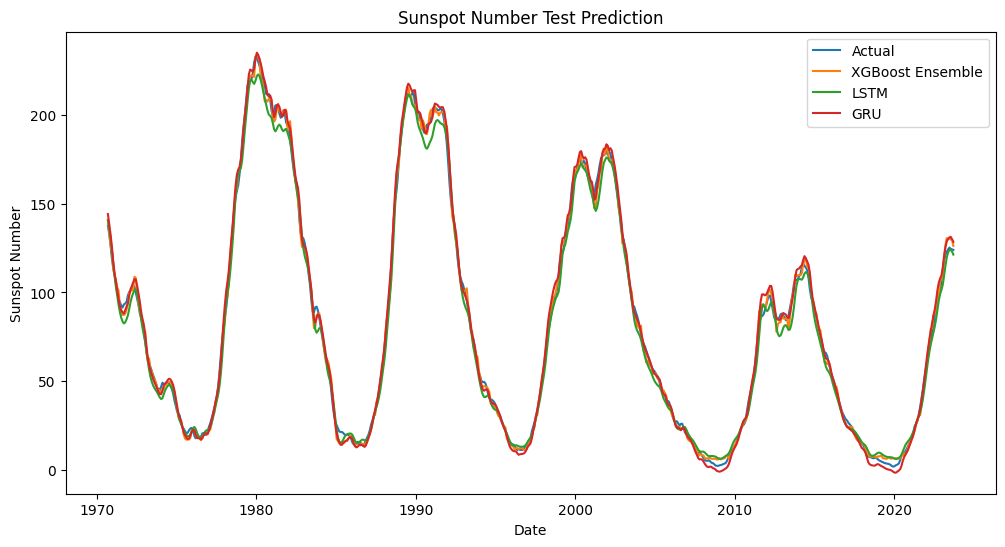

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(Test_Dates,y_test_values[:,0], label='Actual')
plt.plot(Test_Dates,final_preds_values[:,0], label='XGBoost Ensemble')
plt.plot(Test_Dates,lstm_test_preds_values[:,0], label='LSTM')
plt.plot(Test_Dates,gru_test_preds_values[:,0], label='GRU')
plt.xlabel('Date')
plt.ylabel('Sunspot Number')
plt.title('Sunspot Number Test Prediction')
plt.legend()
plt.show()
plt.savefig('test_prediction_plot.eps', format='eps', dpi=300)


## Model Evaluation

### LSTM

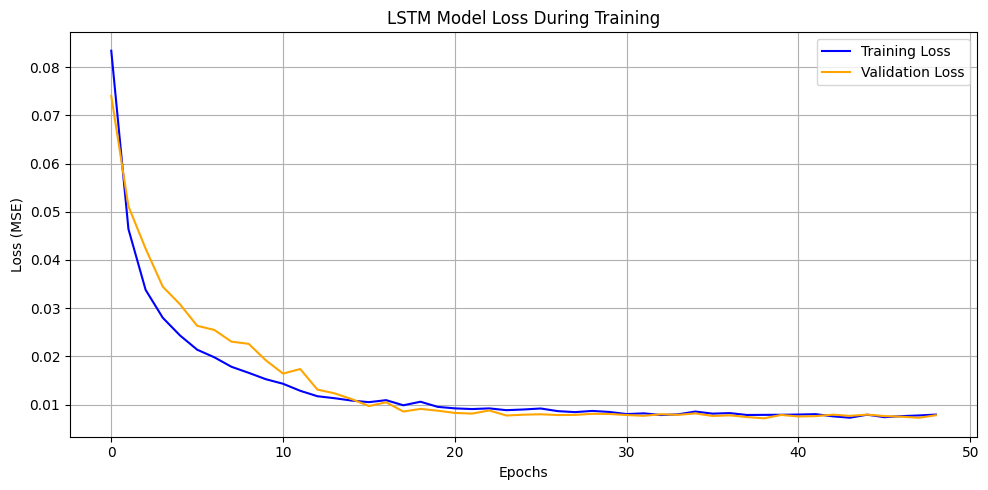

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have saved the history from model.fit()
# For example:
# history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_val, y_val))

# Plot the loss curves
plt.figure(figsize=(10, 5))
plt.plot(history_lstm.history['loss'], label='Training Loss', color='blue')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss', color='orange')
plt.title('LSTM Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
plt.savefig('lstm_model_loss.eps', format='eps', dpi=300)


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def evaluate(model, X, y_true):
    y_pred = model.predict(X)
    rmse = np.sqrt(mean_squared_error(scalers['values'].inverse_transform(y_true).flatten(), scalers['values'].inverse_transform(y_pred).flatten()))
    mae = mean_absolute_error(scalers['values'].inverse_transform(y_true).flatten(), scalers['values'].inverse_transform(y_pred).flatten())
    return rmse, mae

train_rmse_lstm, train_mae_lstm = evaluate(model_lstm, X_train, y_train)
val_rmse_lstm, val_mae_lstm = evaluate(model_lstm, X_val, y_val)
test_rmse_lstm, test_mae_lstm = evaluate(model_lstm, X_test, y_test)

print(f"Train RMSE: {train_rmse_lstm:.2f}, MAE: {train_mae_lstm:.2f}")
print(f"Val   RMSE: {val_rmse_lstm:.2f}, MAE: {val_mae_lstm:.2f}")
print(f"Test  RMSE: {test_rmse_lstm:.2f}, MAE: {test_mae_lstm:.2f}")


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Train RMSE: 17.88, MAE: 12.62
Val   RMSE: 22.42, MAE: 16.21
Test  RMSE: 21.13, MAE: 15.69


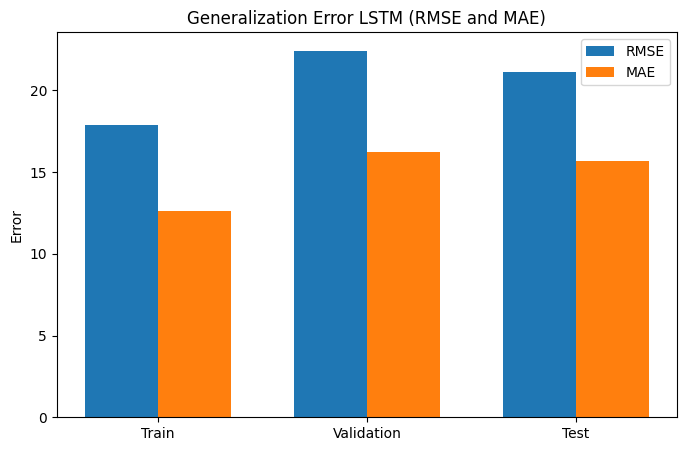

In [ ]:
import matplotlib.pyplot as plt

labels = ['Train', 'Validation', 'Test']
rmses_lstm = [train_rmse_lstm, val_rmse_lstm, test_rmse_lstm]
maes_lstm = [train_mae_lstm, val_mae_lstm, test_mae_lstm]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width/2, rmses_lstm, width, label='RMSE')
rects2 = ax.bar(x + width/2, maes_lstm, width, label='MAE')

ax.set_ylabel('Error')
ax.set_title('Generalization Error LSTM (RMSE and MAE)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.show()
plt.savefig('lstm_generalization_plot.eps', format='eps', dpi=300)


### GRU

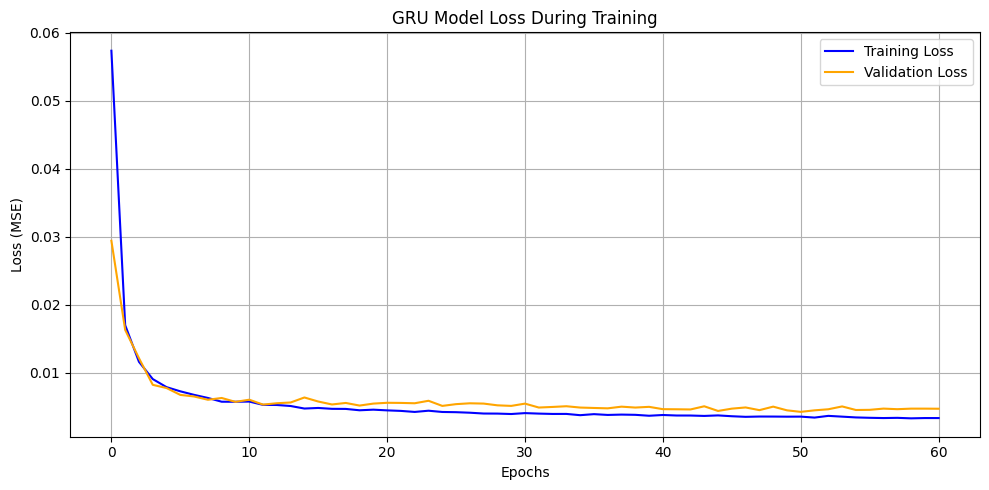

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have saved the history from model.fit()
# For example:
# history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_val, y_val))

# Plot the loss curves
plt.figure(figsize=(10, 5))
plt.plot(history_gru.history['loss'], label='Training Loss', color='blue')
plt.plot(history_gru.history['val_loss'], label='Validation Loss', color='orange')
plt.title('GRU Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
plt.savefig('gru_model_loss_plot.eps', format='eps', dpi=300)


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

'''def evaluate(model, X, y_true):
    y_pred = model.predict(X)
    rmse = np.sqrt(mean_squared_error(scalers['values'].inverse_transform(y_true).flatten(), scalers['values'].inverse_transform(y_pred).flatten()))
    mae = mean_absolute_error(scalers['values'].inverse_transform(y_true).flatten(), scalers['values'].inverse_transform(y_pred).flatten())
    return rmse, mae'''

train_rmse_gru, train_mae_gru = evaluate(model_gru, X_train, y_train)
val_rmse_gru, val_mae_gru = evaluate(model_gru, X_val, y_val)
test_rmse_gru, test_mae_gru= evaluate(model_gru, X_test, y_test)

print(f"Train RMSE: {train_rmse_gru:.2f}, MAE: {train_mae_gru:.2f}")
print(f"Val   RMSE: {val_rmse_gru:.2f}, MAE: {val_mae_gru:.2f}")
print(f"Test  RMSE: {test_rmse_gru:.2f}, MAE: {test_mae_gru:.2f}")


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Train RMSE: 14.24, MAE: 9.61
Val   RMSE: 17.24, MAE: 11.87
Test  RMSE: 16.06, MAE: 11.13


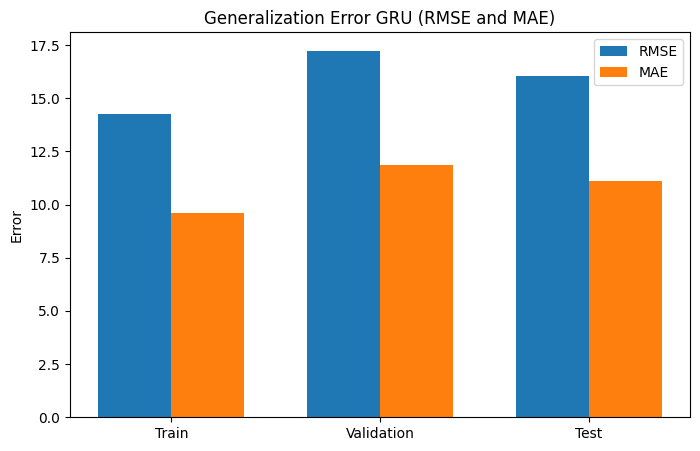

In [ ]:
import matplotlib.pyplot as plt

labels = ['Train', 'Validation', 'Test']
rmses_gru = [train_rmse_gru, val_rmse_gru, test_rmse_gru]
maes_gru = [train_mae_gru, val_mae_gru, test_mae_gru]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width/2, rmses_gru, width, label='RMSE')
rects2 = ax.bar(x + width/2, maes_gru, width, label='MAE')

ax.set_ylabel('Error')
ax.set_title('Generalization Error GRU (RMSE and MAE)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.show()
plt.savefig('gru_generalization error_plot.eps', format='eps', dpi=300)

In [ ]:
print(y_test_values.shape,final_preds_values.shape,lstm_test_preds_values.shape)

NameError: name 'final_preds_values' is not defined

### Ensemble

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

train_rmse_xgb, train_mae_xgb = evaluate(xgb_meta, stacked_features, y_val)
#val_rmse_xgb, val_mae_xgb = evaluate(xgb_meta, X_val, y_val)
test_rmse_xgb, test_mae_xgb= evaluate(xgb_meta, stacked_test, y_test)
print(f"Train RMSE: {train_rmse_xgb:.2f}, MAE: {train_mae_xgb:.2f}")
#print(f"Val   RMSE: {val_rmse_gru:.2f}, MAE: {val_mae_gru:.2f}")
print(f"Test  RMSE: {test_rmse_xgb:.2f}, MAE: {test_mae_xgb:.2f}")


'''rmse = np.sqrt(mean_squared_error(scalers['values'].inverse_transform(y_test.reshape(-1, 1)).flatten(), scalers['values'].inverse_transform(final_preds.reshape(-1, 1)).flatten()))
mae = mean_absolute_error(scalers['values'].inverse_transform(y_test.reshape(-1, 1)).flatten(), scalers['values'].inverse_transform(final_preds.reshape(-1, 1)).flatten())



rmse = np.sqrt(mean_squared_error(y_test_values, final_preds_values))
mae = mean_absolute_error(y_test_values, final_preds_values)
rmse_lstm=np.sqrt(mean_squared_error(y_test_values, lstm_test_preds_values))
mae_lstm=mean_absolute_error(y_test_values, lstm_test_preds_values)
rmse_gru=np.sqrt(mean_squared_error(y_test_values, gru_test_preds_values))
mae_gru=mean_absolute_error(y_test_values, gru_test_preds_values)
print(f"RMSE on test set for ensemble: {rmse:.4f}")
print(f"MAE on test set for ensemble:  {mae:.4f}")
print(f"RMSE on test set for lstm: {rmse_lstm:.4f}")
print(f"MAE on test setfor lstm:  {mae_lstm:.4f}")
print(f"RMSE on test set for gru: {rmse_gru:.4f}")
print(f"MAE on test set for gru:  {mae_gru:.4f}")'''

Train RMSE: 3.08, MAE: 2.06
Test  RMSE: 17.77, MAE: 11.45


'rmse = np.sqrt(mean_squared_error(scalers[\'values\'].inverse_transform(y_test.reshape(-1, 1)).flatten(), scalers[\'values\'].inverse_transform(final_preds.reshape(-1, 1)).flatten()))\nmae = mean_absolute_error(scalers[\'values\'].inverse_transform(y_test.reshape(-1, 1)).flatten(), scalers[\'values\'].inverse_transform(final_preds.reshape(-1, 1)).flatten())\n\n\n\nrmse = np.sqrt(mean_squared_error(y_test_values, final_preds_values))\nmae = mean_absolute_error(y_test_values, final_preds_values)\nrmse_lstm=np.sqrt(mean_squared_error(y_test_values, lstm_test_preds_values))\nmae_lstm=mean_absolute_error(y_test_values, lstm_test_preds_values)\nrmse_gru=np.sqrt(mean_squared_error(y_test_values, gru_test_preds_values))\nmae_gru=mean_absolute_error(y_test_values, gru_test_preds_values)\nprint(f"RMSE on test set for ensemble: {rmse:.4f}")\nprint(f"MAE on test set for ensemble:  {mae:.4f}")\nprint(f"RMSE on test set for lstm: {rmse_lstm:.4f}")\nprint(f"MAE on test setfor lstm:  {mae_lstm:.4f}")

 ## Forecasting Future Predictions for rest of cycle 25 and cycle 26

In [ ]:
# Use the last available 13-step input from the scaled features
last_seq = df[["values_scaled", "month_scaled", "year_scaled"]].values[-seq_length:]
input_seq = last_seq.reshape(1, seq_length, 3)  # (1, seq_len, features)


KeyError: "None of [Index(['values_scaled', 'month_scaled', 'year_scaled'], dtype='object')] are in the [columns]"

Creating a date column fron the Decimal Dates

In [ ]:

import numpy as np



# Convert decimal date to datetime
def decimal_to_date(dec):
    year = int(dec)
    start = pd.Timestamp(f'{year}-01-01')
    end = pd.Timestamp(f'{year + 1}-01-01')
    days_in_year = (end - start).days
    fractional = dec - year
    return start + pd.to_timedelta(fractional * days_in_year, unit='D')

# Apply the conversion
date_series = pd.to_datetime([decimal_to_date(d) for d in df["Decimal_date"]])

# Create DataFrame
df["Date"] = date_series


print(df)


      values  Decimal_date  month  year  values_scaled  year_scaled  \
0       -1.0      1749.042      1  1749       0.000000     0.000000   
1       -1.0      1749.123      2  1749       0.000000     0.000000   
2       -1.0      1749.204      3  1749       0.000000     0.000000   
3       -1.0      1749.288      4  1749       0.000000     0.000000   
4       -1.0      1749.371      5  1749       0.000000     0.000000   
...      ...           ...    ...   ...            ...          ...   
3304   149.1      2024.373      5  2024       0.565775     1.666667   
3305   152.8      2024.455      6  2024       0.579721     1.666667   
3306   155.0      2024.540      7  2024       0.588014     1.666667   
3307   156.8      2024.624      8  2024       0.594798     1.666667   
3308   159.3      2024.706      9  2024       0.604222     1.666667   

                              Date  
0    1749-01-16 07:55:11.999997364  
1    1749-02-14 21:28:48.000001494  
2    1749-03-16 11:02:23.999998453  

### Multi step forecasting

without month , with sin cyle and cos cycle

In [ ]:
# Precompute cycle length (132 months)
CYCLE_LENGTH = 132

# Keep track of months since start of dataset
month_index = len(df)

last_seq = df[["values_scaled", "year_scaled", "sin_cycle_scaled", "cos_cycle_scaled"]].values[-seq_length:]
input_seq = last_seq.reshape(1, seq_length, 4)

future_preds = []
future_preds_lstm=[]
future_preds_gru=[]
future_steps = 132*2
last_date = df["Date"].iloc[-1]

for _ in range(future_steps // seq_length):
    lstm_out = model_lstm.predict(input_seq, verbose=0)[0]  # shape: (13,)
    gru_out = model_gru.predict(input_seq, verbose=0)[0]
    future_preds_lstm.extend(lstm_out)
    future_preds_gru.extend(gru_out)

    meta_input = np.concatenate([lstm_out, gru_out])  # shape: (26,)
    next_13 = xgb_meta.predict(meta_input.reshape(1, -1))[0]
    future_preds.extend(next_13)

    for val in next_13:
        last_date = last_date + pd.DateOffset(months=1)
        y = last_date.year
        y_scaled = scalers["year"].transform([[y]])[0][0]

        # --- recompute cycle features from month index ---
        sin_cycle = np.sin(2 * np.pi * month_index / CYCLE_LENGTH)
        cos_cycle = np.cos(2 * np.pi * month_index / CYCLE_LENGTH)

        # scale them using the same scalers you fit earlier
        sin_cycle_scaled = scalers["sin_cycle"].transform([[sin_cycle]])[0][0]
        cos_cycle_scaled = scalers["cos_cycle"].transform([[cos_cycle]])[0][0]

        # update input with all 4 features again
        new_vector = np.array([val, y_scaled, sin_cycle_scaled, cos_cycle_scaled]).reshape(1, 1, 4)
        input_seq = np.append(input_seq[:, 1:, :], new_vector, axis=1)

        # increment month index
        month_index += 1

# Inverse transform values
predicted_values_xgb = scalers["values"].inverse_transform(np.array(future_preds).reshape(-1, 1)).flatten()
predicted_values_lstm = scalers["values"].inverse_transform(np.array(future_preds_lstm).reshape(-1, 1)).flatten()
predicted_values_gru = scalers["values"].inverse_transform(np.array(future_preds_gru).reshape(-1, 1)).flatten()
# Generate future dates
future_dates = pd.date_range(start=df["Date"].iloc[-1] + pd.DateOffset(months=1), periods=len(predicted_values_xgb), freq='M')

forecast_df_13 = pd.DataFrame({
    "date": future_dates,
    "predicted_value": predicted_values_xgb,
    "predicted_value_lstm":predicted_values_lstm,
    "predicted_value_gru":predicted_values_gru
})


KeyError: "['sin_cycle_scaled', 'cos_cycle_scaled'] not in index"

In [ ]:
# Start from the last available sequence

import warnings
warnings.filterwarnings("ignore")

last_seq = df[["values_scaled", "year_scaled", "sin_cycle_scaled", "cos_cycle_scaled"]].values[-seq_length:]
input_seq = last_seq.reshape(1, seq_length, 2)

future_preds = []
future_preds_lstm=[]
future_preds_gru=[]
future_steps = 132*2
last_date = df["Date"].iloc[-1]

for _ in range(future_steps // seq_length):
    # Get base model predictions
    lstm_out = model_lstm.predict(input_seq, verbose=0)[0]  # shape: (13,)
    gru_out = model_gru.predict(input_seq, verbose=0)[0]    # shape: (13,)
    future_preds_lstm.extend(lstm_out)
    future_preds_gru.extend(gru_out)

    # Stack LSTM and GRU outputs as features for XGBoost
    meta_input = np.concatenate([lstm_out, gru_out])  # shape: (26,)
    next_13 = xgb_meta.predict(meta_input.reshape(1, -1))[0]
    future_preds.extend(next_13)
    #future_preds.append(next_13)
    print(next_13)

    # For each predicted value, generate corresponding month/year
    for val in next_13:
        last_date = last_date + pd.DateOffset(months=1)
        #m = last_date.month
        y = last_date.year
        #m_scaled = scalers["month"].transform([[m]])[0][0]
        y_scaled = scalers["year"].transform([[y]])[0][0]

        # Create new input vector and update sequence
        new_vector = np.array([val,  y_scaled]).reshape(1, 1, 2)
        input_seq = np.append(input_seq[:, 1:, :], new_vector, axis=1)



# Inverse transform values
predicted_values_xgb = scalers["values"].inverse_transform(np.array(future_preds).reshape(-1, 1)).flatten()
predicted_values_lstm = scalers["values"].inverse_transform(np.array(future_preds_lstm).reshape(-1, 1)).flatten()
predicted_values_gru = scalers["values"].inverse_transform(np.array(future_preds_gru).reshape(-1, 1)).flatten()
# Generate future dates
future_dates = pd.date_range(start=df["Date"].iloc[-1] + pd.DateOffset(months=1), periods=len(predicted_values_xgb), freq='M')

forecast_df_13 = pd.DataFrame({
    "date": future_dates,
    "predicted_value": predicted_values_xgb,
    "predicted_value_lstm":predicted_values_lstm,
    "predicted_value_gru":predicted_values_gru
})


[0.543352   0.5564753  0.5611257  0.5685743  0.5548971  0.5546071
 0.53412265 0.52733445 0.5247756  0.53708476 0.5203781  0.4759231
 0.47200868 0.45101672 0.4534034  0.43661055 0.43109602 0.4118332
 0.40291515 0.3831827  0.4132031  0.39610565 0.38647312 0.38722077]
[0.37479436 0.37693784 0.3762688  0.4055646  0.41563398 0.37434617
 0.33207822 0.30834037 0.29534778 0.28817177 0.2751993  0.26939005
 0.2720102  0.28349274 0.28118935 0.26432416 0.26431915 0.23601776
 0.21205491 0.24321505 0.22695641 0.22050403 0.19450675 0.1871869 ]
[0.17483792 0.16794482 0.16795848 0.15855776 0.15534419 0.15200393
 0.14725895 0.14619452 0.14561512 0.14280885 0.13097915 0.12375585
 0.12085233 0.12178901 0.11228062 0.09743377 0.08373476 0.08706699
 0.08425525 0.07453404 0.07064848 0.07056706 0.06564344 0.06577443]
[0.06158815 0.05353912 0.04991307 0.04726415 0.04705763 0.05089936
 0.05724369 0.06772233 0.07186827 0.08621912 0.07761065 0.07179029
 0.07067852 0.08627911 0.10862191 0.11895528 0.14145657 0.1609

with month and year

In [ ]:
# Start from the last available sequence

import warnings
warnings.filterwarnings("ignore")

last_seq = df[["values_scaled", "month_scaled", "year_scaled"]].values[-seq_length:]
input_seq = last_seq.reshape(1, seq_length, 3)

future_preds = []
future_preds_lstm=[]
future_preds_gru=[]
future_steps = 132*2
last_date = df["Date"].iloc[-1]

for _ in range(future_steps // seq_length):
    # Get base model predictions
    lstm_out = model_lstm.predict(input_seq, verbose=0)[0]  # shape: (13,)
    gru_out = model_gru.predict(input_seq, verbose=0)[0]    # shape: (13,)
    future_preds_lstm.extend(lstm_out)
    future_preds_gru.extend(gru_out)

    # Stack LSTM and GRU outputs as features for XGBoost
    meta_input = np.concatenate([lstm_out, gru_out])  # shape: (26,)
    next_13 = xgb_meta.predict(meta_input.reshape(1, -1))[0]
    future_preds.extend(next_13)
    #future_preds.append(next_13)
    print(next_13)

    # For each predicted value, generate corresponding month/year
    for val in next_13:
        last_date = last_date + pd.DateOffset(months=1)
        m = last_date.month
        y = last_date.year
        m_scaled = scalers["month"].transform([[m]])[0][0]
        y_scaled = scalers["year"].transform([[y]])[0][0]

        # Create new input vector and update sequence
        new_vector = np.array([val, m_scaled, y_scaled]).reshape(1, 1, 3)
        input_seq = np.append(input_seq[:, 1:, :], new_vector, axis=1)



# Inverse transform values
predicted_values_xgb = scalers["values"].inverse_transform(np.array(future_preds).reshape(-1, 1)).flatten()
predicted_values_lstm = scalers["values"].inverse_transform(np.array(future_preds_lstm).reshape(-1, 1)).flatten()
predicted_values_gru = scalers["values"].inverse_transform(np.array(future_preds_gru).reshape(-1, 1)).flatten()
# Generate future dates
future_dates = pd.date_range(start=df["Date"].iloc[-1] + pd.DateOffset(months=1), periods=len(predicted_values_xgb), freq='M')

forecast_df_13 = pd.DataFrame({
    "date": future_dates,
    "predicted_value": predicted_values_xgb,
    "predicted_value_lstm":predicted_values_lstm,
    "predicted_value_gru":predicted_values_gru
})


[0.56446517 0.5695226  0.57093966 0.58295333 0.57747823 0.6208074
 0.6232097  0.59380996 0.59929556 0.572181   0.5820581  0.5999587
 0.6055164 ]
[0.5914285  0.5981703  0.5881834  0.58662546 0.58727604 0.59520817
 0.57860684 0.57061553 0.55530316 0.5356173  0.5384739  0.52836317
 0.51318675]
[0.49497074 0.4826966  0.46247318 0.44021666 0.42785522 0.41087252
 0.38791096 0.3720706  0.36377198 0.36041504 0.3549047  0.35006505
 0.34367448]
[0.32783678 0.31186002 0.3548973  0.34552205 0.31180647 0.2842417
 0.2650294  0.27784553 0.26216868 0.23868236 0.23600435 0.20600364
 0.18531552]
[0.1746148  0.16040199 0.15330812 0.14325623 0.14409746 0.13686164
 0.13291673 0.13463984 0.13086939 0.12621307 0.11690377 0.10848256
 0.09607422]
[0.08762848 0.08059154 0.07048933 0.06537088 0.06914792 0.06392278
 0.05425839 0.05497982 0.052244   0.05003736 0.05087992 0.0459042
 0.04699595]
[0.04608389 0.04628027 0.04043957 0.04575817 0.04720303 0.04063805
 0.04432033 0.04914977 0.06777436 0.07176281 0.07849152

 without month

In [ ]:
# Start from the last available sequence

import warnings
warnings.filterwarnings("ignore")

last_seq = df[["values_scaled",  "year_scaled"]].values[-seq_length:]
input_seq = last_seq.reshape(1, seq_length, 2)

future_preds = []
future_preds_lstm=[]
future_preds_gru=[]
future_steps = 132*2
last_date = df["Date"].iloc[-1]

for _ in range(future_steps // seq_length):
    # Get base model predictions
    lstm_out = model_lstm.predict(input_seq, verbose=0)[0]  # shape: (13,)
    gru_out = model_gru.predict(input_seq, verbose=0)[0]    # shape: (13,)
    future_preds_lstm.extend(lstm_out)
    future_preds_gru.extend(gru_out)

    # Stack LSTM and GRU outputs as features for XGBoost
    meta_input = np.concatenate([lstm_out, gru_out])  # shape: (26,)
    next_13 = xgb_meta.predict(meta_input.reshape(1, -1))[0]
    future_preds.extend(next_13)
    #future_preds.append(next_13)
    print(next_13)

    # For each predicted value, generate corresponding month/year
    for val in next_13:
        last_date = last_date + pd.DateOffset(months=1)
        m = last_date.month
        y = last_date.year
        #m_scaled = scalers["month"].transform([[m]])[0][0]
        y_scaled = scalers["year"].transform([[y]])[0][0]

        # Create new input vector and update sequence
        new_vector = np.array([val, y_scaled]).reshape(1, 1, 2)
        input_seq = np.append(input_seq[:, 1:, :], new_vector, axis=1)



# Inverse transform values
predicted_values_xgb = scalers["values"].inverse_transform(np.array(future_preds).reshape(-1, 1)).flatten()
predicted_values_lstm = scalers["values"].inverse_transform(np.array(future_preds_lstm).reshape(-1, 1)).flatten()
predicted_values_gru = scalers["values"].inverse_transform(np.array(future_preds_gru).reshape(-1, 1)).flatten()
# Generate future dates
future_dates = pd.date_range(start=df["Date"].iloc[-1] + pd.DateOffset(months=1), periods=len(predicted_values_xgb), freq='M')

forecast_df_13 = pd.DataFrame({
    "date": future_dates,
    "predicted_value": predicted_values_xgb,
    "predicted_value_lstm":predicted_values_lstm,
    "predicted_value_gru":predicted_values_gru
})


[0.59640294 0.61833364 0.6110584  0.62948185 0.62931836 0.62368655
 0.60877603 0.64518565 0.64987427 0.65579873 0.65930897 0.64104414
 0.63195086]
[0.64048946 0.64485306 0.6509772  0.6443471  0.63079715 0.6229065
 0.6379506  0.61102223 0.5986531  0.6005474  0.57576734 0.56759554
 0.5784174 ]
[0.5714091  0.5542441  0.5462089  0.5293418  0.49744377 0.46700642
 0.45821872 0.44002604 0.40070376 0.39134404 0.3805138  0.40101093
 0.35810152]
[0.34627616 0.3305938  0.30110753 0.2896217  0.2827792  0.28773808
 0.2896898  0.2765185  0.26070833 0.23236321 0.21590798 0.22214526
 0.20998113]
[0.20792516 0.20319922 0.19817777 0.19439647 0.18838522 0.18711449
 0.18711798 0.16870686 0.16319585 0.16542587 0.15597883 0.15711237
 0.14495285]
[0.13788405 0.12815233 0.12450165 0.11944724 0.12005328 0.11494059
 0.09278478 0.08612388 0.07452344 0.0773835  0.07145315 0.0668442
 0.06203957]
[0.05687262 0.05804345 0.05419397 0.04854584 0.0390201  0.04060547
 0.03331745 0.03586446 0.04148893 0.05119917 0.053308

### Single step forecasting

In [ ]:
import warnings
warnings.filterwarnings("ignore")

last_seq = df[["values_scaled", "month_scaled", "year_scaled"]].values[-seq_length:]
input_seq = last_seq.reshape(1, seq_length, 3)

future_preds = []
future_preds_lstm = []
future_preds_gru = []

future_steps = 132 * 2
last_date = df["Date"].iloc[-1]

for _ in range(future_steps):
    # Predict next value using LSTM and GRU
    lstm_out = model_lstm.predict(input_seq, verbose=0)[0][0]  # scalar
    gru_out = model_gru.predict(input_seq, verbose=0)[0][0]    # scalar

    future_preds_lstm.append(lstm_out)
    future_preds_gru.append(gru_out)

    # Combine as feature input for XGBoost
    meta_input = np.array([lstm_out, gru_out]).reshape(1, -1)
    next_val = xgb_meta.predict(meta_input)[0]  # scalar
    future_preds.append(next_val)

    # Update the input sequence
    last_date = last_date + pd.DateOffset(months=1)
    m = last_date.month
    y = last_date.year
    m_scaled = scalers["month"].transform([[m]])[0][0]
    y_scaled = scalers["year"].transform([[y]])[0][0]

    new_vector = np.array([next_val, m_scaled, y_scaled]).reshape(1, 1, 3)
    input_seq = np.append(input_seq[:, 1:, :], new_vector, axis=1)

# Inverse transform predictions
predicted_values_xgb = scalers["values"].inverse_transform(np.array(future_preds).reshape(-1, 1)).flatten()
predicted_values_lstm = scalers["values"].inverse_transform(np.array(future_preds_lstm).reshape(-1, 1)).flatten()
predicted_values_gru = scalers["values"].inverse_transform(np.array(future_preds_gru).reshape(-1, 1)).flatten()

# Create future dates
future_dates = pd.date_range(start=df["Date"].iloc[-1] + pd.DateOffset(months=1), periods=len(predicted_values_xgb), freq='M')

# Combine into DataFrame
forecast_df = pd.DataFrame({
    "date": future_dates,
    "predicted_value_xgb": predicted_values_xgb,
    "predicted_value_lstm": predicted_values_lstm,
    "predicted_value_gru": predicted_values_gru
})


Not this

In [ ]:

import warnings
warnings.filterwarnings("ignore")

# Initialize last known sequence
last_seq = df[["values_scaled", "month_scaled", "year_scaled"]].values[-seq_length:]  # seq_length = 11
input_seq = last_seq.reshape(1, seq_length, 3)

future_preds = []
future_preds_lstm = []
future_preds_gru = []
future_steps = 132 * 2  # Total future months to predict
last_date = df["Date"].iloc[-1]

for _ in range(future_steps):
    # Predict next value from LSTM and GRU (each returns a scalar)
    lstm_out = model_lstm.predict(input_seq, verbose=0)[0][0]  # shape: scalar
    gru_out = model_gru.predict(input_seq, verbose=0)[0][0]    # shape: scalar
    future_preds_lstm.append(lstm_out)
    future_preds_gru.append(gru_out)

    # Use LSTM + GRU outputs as features for meta model (XGBoost)
    meta_input = np.array([lstm_out, gru_out])
    next_value = xgb_meta.predict(meta_input.reshape(1, -1))[0]
    future_preds.append(next_value)
    #print(next_value)

    # Update date
    last_date = last_date + pd.DateOffset(months=1)
    m = last_date.month
    y = last_date.year
    m_scaled = scalers["month"].transform([[m]])[0][0]
    y_scaled = scalers["year"].transform([[y]])[0][0]

    # Update sequence by appending new input and shifting
    new_vector = np.array([next_value, m_scaled, y_scaled]).reshape(1, 1, 3)
    input_seq = np.append(input_seq[:, 1:, :], new_vector, axis=1)  # keep input length = 11

# Inverse scale the predictions
predicted_values_xgb = scalers["values"].inverse_transform(np.array(future_preds).reshape(-1, 1)).flatten()
predicted_values_lstm = scalers["values"].inverse_transform(np.array(future_preds_lstm).reshape(-1, 1)).flatten()
predicted_values_gru = scalers["values"].inverse_transform(np.array(future_preds_gru).reshape(-1, 1)).flatten()

# Generate future dates
future_dates = pd.date_range(start=df["Date"].iloc[-1] + pd.DateOffset(months=1), periods=len(predicted_values_xgb), freq='M')

# Final forecast dataframe
forecast_df_13 = pd.DataFrame({
    "date": future_dates,
    "predicted_value": predicted_values_xgb,
    "predicted_value_lstm": predicted_values_lstm,
    "predicted_value_gru": predicted_values_gru
})


In [ ]:
forecast_df_13.head(5)

,date,predicted_value,predicted_value_lstm,predicted_value_gru
0,2024-10-31 09:30:14.399996950,159.900131,161.198761,161.921463
1,2024-11-30 09:30:14.399996950,159.976562,158.826096,162.439758
2,2024-12-31 09:30:14.399996950,162.312485,157.476120,163.392639
3,2025-01-31 09:30:14.399996950,161.015503,155.925735,163.492310
4,2025-02-28 09:30:14.399996950,164.100586,157.287216,163.751450


### Plotting

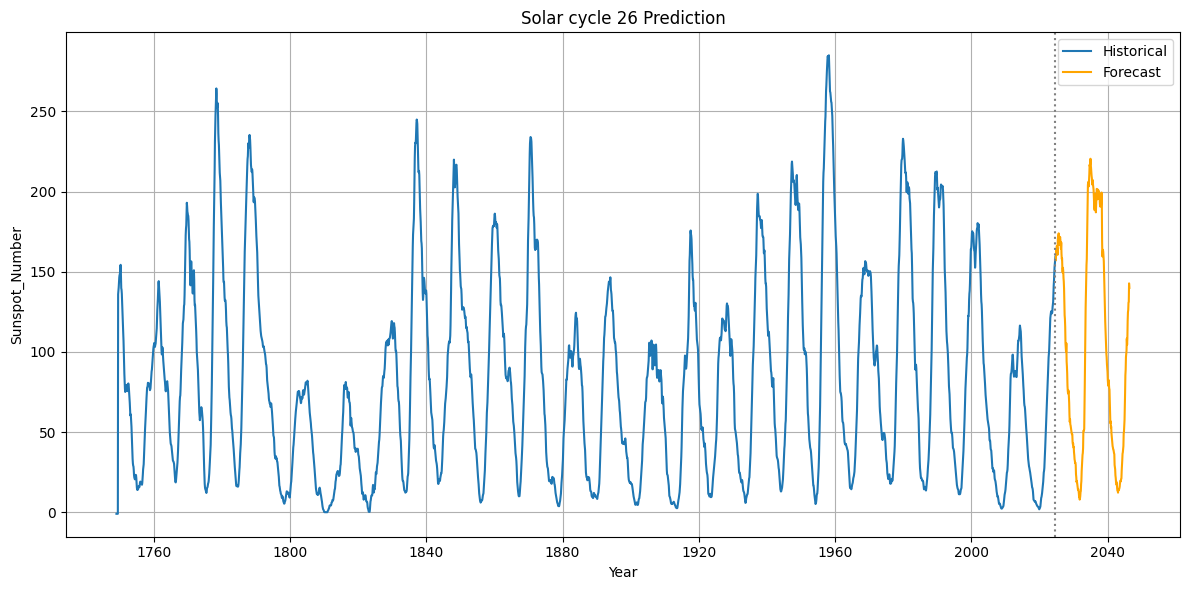

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df["Date"], df["values"], label="Historical")
plt.plot(forecast_df_13['date'], forecast_df_13["predicted_value"], label="Forecast", color="orange")
plt.axvline(x=df["Date"].iloc[-1], color="gray", linestyle=":")
plt.title("Solar cycle 26 Prediction")
plt.xlabel("Year")
plt.ylabel("Sunspot_Number")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


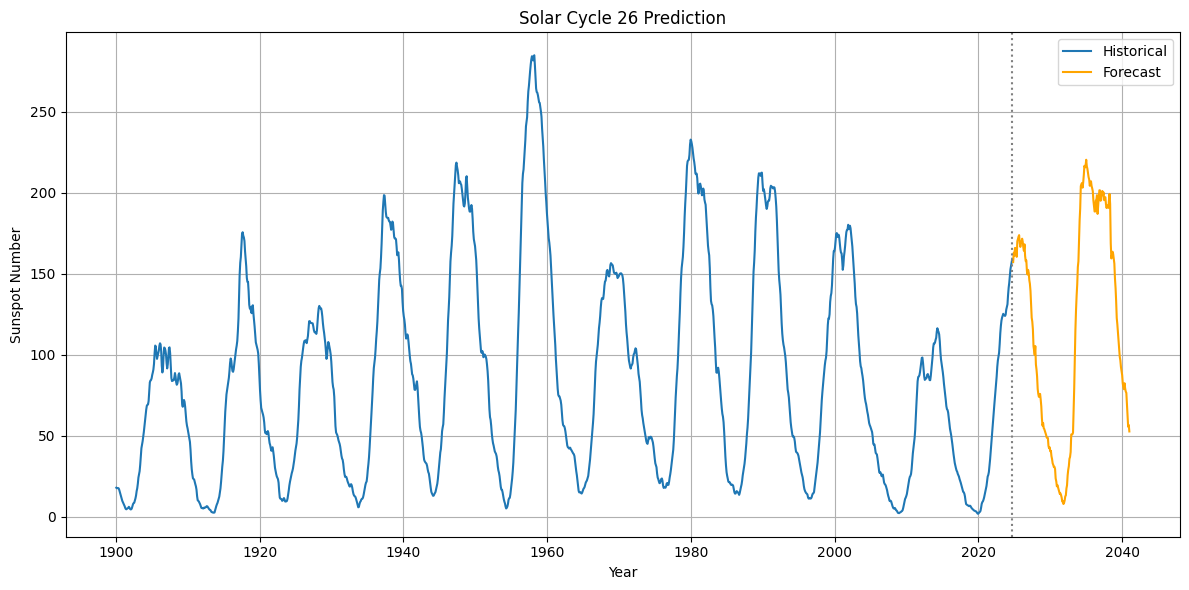

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot only from year 1900 onward
mask = df["Date"].dt.year >= 1900
mask_end=(forecast_df_13["date"].dt.year <= 2040)
plt.plot(df["Date"][mask], df["values"][mask], label="Historical")

# Plot the forecast
plt.plot(forecast_df_13['date'][mask_end], forecast_df_13["predicted_value"][mask_end], label="Forecast", color="orange")

# Add a vertical line at the transition from historical to forecast
plt.axvline(x=df["Date"].iloc[-1], color="gray", linestyle=":")

plt.title("Solar Cycle 26 Prediction")
plt.xlabel("Year")
plt.ylabel("Sunspot Number")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
plt.savefig('solar_cycle_26.eps', format='eps', dpi=300)

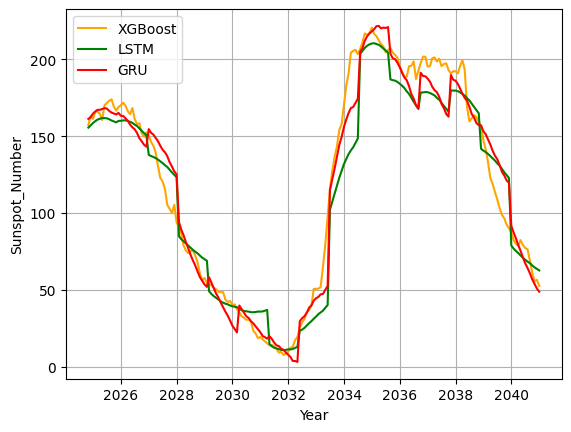

In [ ]:
plt.plot(forecast_df_13["date"][mask_end], forecast_df_13["predicted_value"][mask_end], label="XGBoost", color="orange")
plt.plot(forecast_df_13["date"][mask_end], forecast_df_13["predicted_value_lstm"][mask_end], label="LSTM", color="green")
plt.plot(forecast_df_13["date"][mask_end], forecast_df_13["predicted_value_gru"][mask_end], label="GRU", color="red")
plt.xlabel("Year")
plt.ylabel("Sunspot_Number")
plt.grid(True)
plt.legend()
#plt.tight_layout()
plt.show()
plt.savefig('solar_cycle model_comp.eps', format='eps', dpi=300)

### peak sunspot value for cycle 26

In [ ]:
# Filter rows between 2024 and 2030
mask_25 = (forecast_df_13['date'].dt.year >= 2024) & (forecast_df_13['date'].dt.year <= 2030)
filtered_df_25 = forecast_df_13[mask_25]

# Extract the row with the maximum value
max_row_25 = filtered_df_25.loc[filtered_df_25['predicted_value'].idxmax()]

# Output
print("Date of peak value of cycle 25:", max_row_25['date'])
print("peak value:", max_row_25['predicted_value'])

# Filter rows between 2030 and 2040
mask_26 = (forecast_df_13['date'].dt.year >= 2030) & (forecast_df_13['date'].dt.year <= 2040)
filtered_df_26 = forecast_df_13[mask_26]

# Extract the row with the maximum value
max_row_26 = filtered_df_26.loc[filtered_df_26['predicted_value'].idxmax()]

# Output
print("Date of peak value of cycle 26:", max_row_26['date'])
print("peak value:", max_row_26['predicted_value'])
'''
#Confidence Interval
mean_pred = predictions.mean(axis=0)
std_pred = predictions.std(axis=0)

# For 95% confidence interval
upper = mean_pred + 1.96 * std_pred
lower = mean_pred - 1.96 * std_pred
'''

Date of peak value of cycle 25: 2025-05-31 09:30:14.399996950
peak value: 181.63347
Date of peak value of cycle 26: 2036-09-30 09:30:14.399996950
peak value: 204.34492


'\n#Confidence Interval\nmean_pred = predictions.mean(axis=0)\nstd_pred = predictions.std(axis=0)\n\n# For 95% confidence interval\nupper = mean_pred + 1.96 * std_pred\nlower = mean_pred - 1.96 * std_pred\n'

## Synopsis

This notebook performs time series forecasting on sunspot data using a stacked ensemble model of LSTM, GRU, and XGBoost.

1.  **Data Loading and Preprocessing**: The code loads sunspot data from a CSV file, sorts it by date, and performs min-max scaling on the sunspot values, month, and year.
2.  **Feature Engineering**: It creates sequences of scaled features and corresponding target values (sunspot numbers) for training the models.
3.  **Chronological Train-Validation-Test Split**: The data is split into training, validation, and test sets chronologically to maintain the temporal order.
4.  **Model Training**:
    *   A stacked LSTM model is trained on the training data.
    *   A GRU model is also trained on the training data.
5.  **Stacking Features**: Predictions from the trained LSTM and GRU models on the validation set are stacked to be used as input features for the XGBoost model.
6.  **XGBoost Ensemble**: An XGBoost Regressor is trained on the stacked predictions from the validation set, with the true sunspot values as the target.
7.  **Test Prediction**: The trained LSTM and GRU models predict on the test set, their predictions are stacked, and the XGBoost model makes the final predictions on the stacked test predictions.
8.  **Model Evaluation**: The performance of the ensemble model is evaluated using Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE) on the test set.
9.  **Forecasting Future Predictions**: The trained ensemble model is used to forecast future sunspot values for cycle 25 and cycle 26 by iteratively predicting the next 13 steps and using those predictions as part of the input for the subsequent prediction.
10. **Plotting**: The historical data and the forecasted values are plotted to visualize the model's predictions.
11. **Peak Sunspot Value**: The code identifies and prints the date and value of the peak sunspot number predicted for cycles 25 and 26.

## Model Training Details

This section trains three models: a Stacked LSTM, a GRU, and an XGBoost Regressor used as a meta-model in an ensemble.

### Stacked LSTM

*   **Architecture**:
    *   Three stacked LSTM layers with 128, 64, and 32 units respectively. The first LSTM layer has `return_sequences=True` to pass the sequence output to the next LSTM layer. The second LSTM layer also has `return_sequences=True`. The third LSTM layer has `return_sequences=False` as it feeds into a Dense layer.
    *   A Dropout layer with a rate of 0.2 is applied after the last LSTM layer to prevent overfitting.
    *   A final Dense layer with 13 units to output the predicted sequence of 13 values.
*   **Activation Function**: The LSTM layers use the 'tanh' activation function.
*   **Optimizer**: The 'adam' optimizer is used for training.
*   **Loss Function**: Mean Squared Error (MSE) is used as the loss function.
*   **Hyperparameters**:
    *   `epochs`: 40
    *   `batch_size`: 12
    *   `validation_split`: 0.1 (10% of the training data is used for validation during training)
*   **Callbacks**: Early Stopping is used with a `patience` of 5 epochs. This means training will stop if the validation loss does not improve for 5 consecutive epochs, and the best weights from the training run will be restored.

### GRU

*   **Architecture**:
    *   A GRU layer with 64 units. `return_sequences` is set to `False` as it directly feeds into a Dense layer.
    *   A Dropout layer with a rate of 0.2 is applied after the GRU layer.
    *   A final Dense layer with 13 units to output the predicted sequence of 13 values.
*   **Activation Function**: The GRU layer uses the 'tanh' activation function.
*   **Optimizer**: The 'adam' optimizer is used for training.
*   **Loss Function**: Mean Squared Error (MSE) is used as the loss function.
*   **Hyperparameters**:
    *   `epochs`: 100
    *   `batch_size`: 16
    *   `validation_split`: 0.1 (10% of the training data is used for validation during training)
*   **Callbacks**: Early Stopping is used with a `patience` of 10 epochs.

### XGBoost Ensemble (Meta-model)

*   **Purpose**: This model is trained on the predictions of the LSTM and GRU models (stacked features) to make the final prediction.
*   **Model Type**: XGBoost Regressor.
*   **Hyperparameters**:
    *   `n_estimators`: 100 (number of boosting rounds)
    *   `learning_rate`: 0.1 (step size shrinkage used in update to prevent overfitting)
*   **Training Data**: The model is trained on the stacked predictions of the LSTM and GRU models on the **validation set**, using the true values from the validation set as the target. This allows the XGBoost model to learn how to best combine the predictions of the base models.